# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,AvgPool2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

Всего 7591 картинка лиц.

Text(0.5, 1.0, 'Распределение картинок по возрасту')

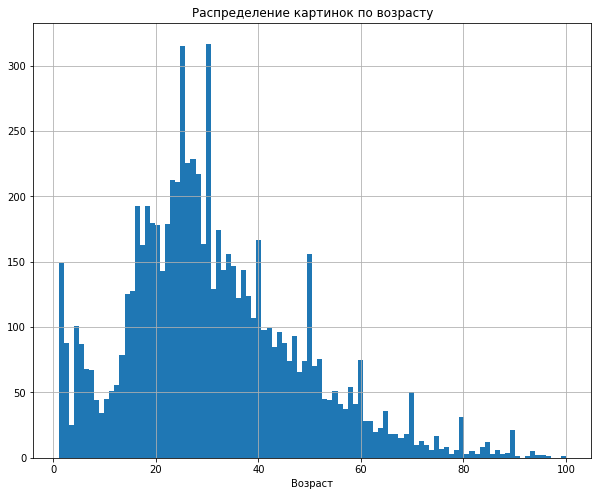

In [3]:
plt.figure(figsize=(10,8))
labels['real_age'].hist(bins=100,range=(1,100))
plt.xlabel('Возраст')
plt.title('Распределение картинок по возрасту')

Видно, что распределение не нормальное. Есть два пика. Распределение скошено в право. Больше всего представлено фотографий людей в возрасте от 20 до 30 лет.

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
features,target=next(train_gen_flow)

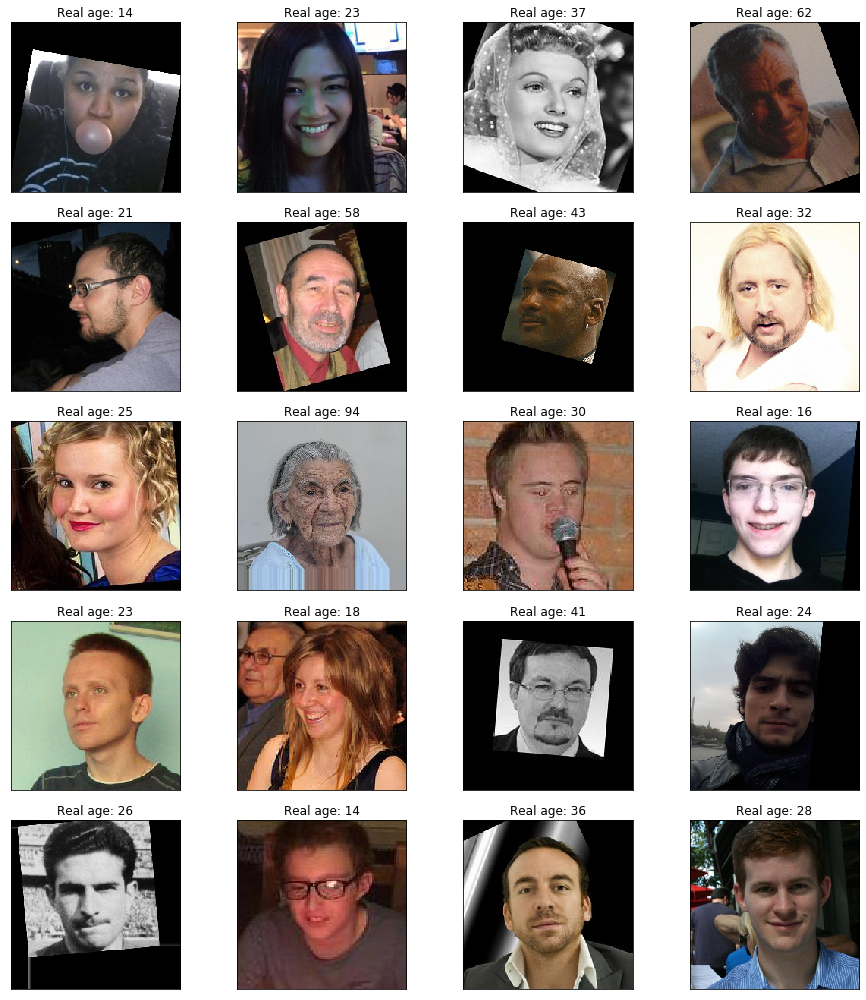

In [6]:
fig = plt.figure(figsize=(14,14))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.title('Real age: ' + str(target[i+10]))
    plt.imshow(features[i+10])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод: По данным исследования распределения по возрасту можно отметить, что модель хорошо обучится на картинках с возрастом от 20 до 30. Они приедставлены в большом объеме. По другим возрастам количество фоторгафий уменьшается. На них модель может чаще ошибаться.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

## Комментарий ревьюера
<span style="color:green">Отличная работа с нейросетью, никаких ошибок нет.</span>

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-10-09 13:12:15.594734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-09 13:12:19.747170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 120s - loss: 216.7399 - mae: 11.0985 - val_loss: 292.1346 - val_mae: 12.8106
Epoch 2/20
356/356 - 42s - loss: 137.4078 - mae: 8.9118 - val_loss: 243.2974 - val_mae: 11.5834
Epoch 3/20
356/356 - 42s - loss: 112.0031 - mae: 8.0481 - val_loss: 117.3335 - val_mae: 8.2798
Epoch 4/20
356/356 - 42s - loss: 94.7241 - mae: 7.4143 - val_loss: 145.1192 - val_mae: 9.5701
Epoch 5/20
356/356 - 42s - loss: 76.9300 - mae: 6.7033 - val_loss: 135.1816 - val_mae: 8.8192
Epoch 6/20
356/356 - 42s - loss: 70.1347 - mae: 6.4509 - val_loss: 229.3464 - val_mae: 10.8719
Epoch 7/20
356/356 - 42s - loss: 57.4269 - mae: 5.8297 - val_loss: 126.9306 - val_mae: 8.2642
Epoch 8/20
356/356 - 42s - loss: 49.3097 - mae: 5.4213 - val_loss: 144.2385 - val_mae: 8.8588
Epoch 9/20
356/356 - 42s - loss: 43.7897 - mae: 5.0977 - val_loss: 177.7840 - val_mae: 9.7732
Epoch 10/20
356/356 - 42s - loss: 37.3928 - mae: 4.7011 - val_loss: 109.4320 - val_mae: 7.8431
Epoch 11/20
356/356 - 42s - loss: 29.3904 - mae: 4.2095 - val_loss: 77.8955 - val_mae: 6.5936
Epoch 12/20
356/356 - 42s - loss: 25.6832 - mae: 3.9221 - val_loss: 110.5957 - val_mae: 7.7312
Epoch 13/20
356/356 - 42s - loss: 24.7617 - mae: 3.8514 - val_loss: 85.8288 - val_mae: 6.9657
Epoch 14/20
356/356 - 43s - loss: 22.4041 - mae: 3.6547 - val_loss: 77.7266 - val_mae: 6.5794
Epoch 15/20
356/356 - 43s - loss: 21.6955 - mae: 3.6211 - val_loss: 94.3256 - val_mae: 7.2458
Epoch 16/20
356/356 - 42s - loss: 21.7143 - mae: 3.5849 - val_loss: 96.6280 - val_mae: 7.3304
Epoch 17/20
356/356 - 43s - loss: 19.5044 - mae: 3.4003 - val_loss: 116.7208 - val_mae: 8.3219
Epoch 18/20
356/356 - 43s - loss: 20.5923 - mae: 3.5114 - val_loss: 106.8278 - val_mae: 7.8279
Epoch 19/20
356/356 - 42s - loss: 19.7896 - mae: 3.4244 - val_loss: 96.1776 - val_mae: 7.4793
Epoch 20/20
356/356 - 42s - loss: 18.8454 - mae: 3.3263 - val_loss: 82.3160 - val_mae: 6.8034
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 82.3160 - mae: 6.8034
Test MAE: 6.8034

```

## Комментарий ревьюера
<span style="color:green">Результат достойный, поздравляю!</span>

# 3. Анализ обученной модели

Для анализа возраста людей по фотографии была использована CCN ResNet50. Было задано 20 эпох и функция оптимизации для нахождения минимума Adam с шагом lr=0.0005. По итогам анализа мы получили значение метрики mean absolute error для обучающей и для валидационной выборки. Значение mae для обучающей получилось 3.3263, а для валидационной mae получилось 6.8034. Модель немного переобучилась. Но разница в 3 года думаю не значительным переобучением и могу сказать, что модель предсказывает хорошо.